In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 09 - CNN with Fibonacci 

### v4 Ensemble

by Louis Yang

Use Fibonacci series median instead of median. The Fib. median are now compute on both training and CV set separately.

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

Test on stage 2 data.

Original model: 'model_7_CNN_with_Fibonacci_8_mean_absolute_error_1_stage_2'

Ensemble: automatically evaluate the same model 4 times

In [2]:
model_name = 'model_9_CNN_with_Fibonacci_4_Ensemble'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_2.csv'

In [5]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file)
print('done!')

%%% Reading data train_2.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [10]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [11]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-04-29', '2016-06-30')

daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

In [12]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [13]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-04-28', '2017-06-29')

daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

weekday(X_input_first_day), weekday(X_output_first_day)

Both are Wednesday (2).

#### Y

In [14]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [15]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-07-01', '2016-09-01')

daydiff(Y_input_first_day, Y_input_final_day)

In [16]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [17]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-06-30', '2017-08-31')

daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

weekday(Y_input_first_day), weekday(Y_output_first_day)

Both are Sunday (6).

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [18]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [19]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
        '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
        ...
        '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24', '2016-06-25',
        '2016-06-26', '2016-06-27', '2016-06-28', '2016-06-29', '2016-06-30'],
       dtype='object', length=329),
 Index(['2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
        '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
        ...
        '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
        '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29'],
       dtype='object', length=329))

In [20]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(4, 4)

In [21]:
fib_output_data = input_df[fib_output_dates].values; fib_output_data

array([[  49.,   10.,   19., ...,   32.,   34.,   21.],
       [  30.,   16.,   54., ...,  127.,  104.,   20.],
       [   7.,    2.,    1., ...,    5.,    5.,    0.],
       ..., 
       [  nan,   nan,   nan, ...,   35.,   46.,   43.],
       [  nan,   nan,   nan, ...,    6.,    6.,    7.],
       [  nan,   nan,   nan, ...,   21.,   20.,   14.]])

In [22]:
fib_input_data = input_df[fib_input_dates].values; fib_input_data

array([[  4.,  11.,  10., ...,  18.,  23.,  12.],
       [  2.,  23.,  12., ...,  24.,  16.,  15.],
       [  5.,   1.,   4., ...,   5.,   1.,   4.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

#### Fibonacci median in each window

In [23]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [24]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [25]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [26]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [27]:
fib_input_median

array([ 16.5 ,  15.25,   4.  , ...,   0.  ,   0.  ,   0.  ])

In [28]:
fib_output_median

array([ 24.  ,  22.5 ,   4.  , ...,  34.  ,   7.75,  11.25])

We will use this as the center and part of the result

In [29]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

input_data contains X_input and Y_input array

In [30]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates, X_input_first_day, Y_input_final_day

(Index(['2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02', '2016-05-03',
        '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
        ...
        '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
        '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01'],
       dtype='object', length=126), '2016-04-29', '2016-09-01')

In [31]:
input_data = input_df[input_dates].values; #input_data  # input_data with nan

##### Convert nan to number 0.

In [32]:
input_data_num = np.nan_to_num(input_data); #input_data_num  # intput_data with nan -> 0.

input_data_num.shape

### Output Data

output_data for this self-testing script contains both X_output and Y_output

In [33]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates, X_output_first_day, X_output_final_day, Y_output_final_day

(Index(['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02',
        '2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07',
        ...
        '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
        '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
       dtype='object', length=126), '2017-04-28', '2017-06-29', '2017-08-31')

In [34]:
output_dates.shape

(126,)

In [35]:
output_data = input_df[output_dates].values; #output_data

##### Convert nan to number 0.

In [36]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 24.,  20.,  36., ...,  26.,  24.,  21.],
       [ 19.,  18.,  12., ...,  29.,  34.,  25.],
       [  2.,   0.,   3., ...,   8.,  12.,   9.],
       ..., 
       [ 27.,  84.,  14., ...,  21.,  11.,   9.],
       [  7.,  10.,  13., ...,   3.,   9.,   2.],
       [ 34.,  16.,  16., ...,   9.,   6.,   5.]])

In [37]:
output_data_num.shape

(145063, 126)

### View

def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
        
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
    
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [38]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [39]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [40]:
input_data_log.shape, input_data.shape, output_data_log.shape, output_data.shape

((145063, 126), (145063, 126), (145063, 126), (145063, 126))

input_data_log

output_data_log

#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [41]:
gc.collect()

283

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [42]:
#input_center = log(fib_input_median).reshape(-1,1)
output_center = log(fib_output_median).reshape(-1,1)
input_center = output_center  # using output_center instead

In [43]:
input_center, output_center

(array([[ 1.39794001],
        [ 1.37106786],
        [ 0.69897   ],
        ..., 
        [ 1.54406804],
        [ 0.94200805],
        [ 1.08813609]]), array([[ 1.39794001],
        [ 1.37106786],
        [ 0.69897   ],
        ..., 
        [ 1.54406804],
        [ 0.94200805],
        [ 1.08813609]]))

#### Choice of default scale

In [44]:
input_raw_log = log(input_data)  # log of input_data with nan
output_raw_log = log(output_data)  # log of output_data with nan

np.median(np.nanstd(input_data_log[:,:x_length], axis=-1))

np.mean(np.nanstd(input_data_log[:,:x_length], axis=-1))

In [45]:
default_input_scale = np.nanmedian(np.nanstd(input_raw_log[:,:x_length], axis=-1))
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17974041809557845

In [46]:
default_output_scale = np.nanmedian(np.nanstd(output_raw_log[:,:x_length], axis=-1))
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.16425448559207598

#### Compute Median and Stdev

Here we are not using this median as center

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [47]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = default_input_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
input_scale  # remember sample-wised scale

array([[ 0.22042467],
       [ 0.1944303 ],
       [ 0.23390395],
       ..., 
       [ 0.17974042],
       [ 0.17974042],
       [ 0.17974042]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [48]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = default_output_scale  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.15715761],
       [ 0.23019142],
       [ 0.29932548],
       ..., 
       [ 0.30635028],
       [ 0.308769  ],
       [ 0.41433723]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [49]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [50]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [51]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [52]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [53]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
#input_gp, output_gp

In [54]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
#gp_input_counts

In [55]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
#gp_output_counts

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

## Make (X,Y) pairs data from data set

In [56]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [57]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) (145063, 63)


#### Original data

In [58]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [59]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

X_input = X_input
Y_input = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

X_input_ori = X_input_ori
Y_input_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

In [60]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -104.945597725 182.183688699 0.0250217121081 3.34816141728
(145063, 63) -104.945597725 181.969627538 -0.0156385758122 3.42135990909
(145063, 63) -57.3465699314 8.00100800101 0.0 1.27077605981
(145063, 63) -1627.7382547 51.3918797946 -0.214767758227 6.0365527548
(145063, 63) 0.0 23209383.0 126.0 63765.8619057
(145063, 63) 0.0 67264258.0 128.0 155483.953622
(145063, 63) 0.0 24630674.0 123.0 65785.6552263
(145063, 63) 0.0 18670230.0 113.0 57469.0537846


#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, train_center, train_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [61]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [62]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [63]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [64]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), 1e-07, None))
    return 200. * np.nanmean(diff, axis=axis)

In [65]:
smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

(200.0, 0.0)

In [66]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(118.39849931396679, 148.1903381452849, 0.0)

In [67]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(60.417294139521594, 58.828327132034431)

In [68]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

50.9386336667 142.088333627


In [69]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

48.3250071896
40.4041165988


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [70]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D

In [190]:
n_ensemble = 4
ensemble_list = list(range(n_ensemble))

In [191]:
#runbelow
models_ensemble = []
for run in ensemble_list:
    models = []
    for gp in gp_list:
        print('Group:', gp)
        layer_0 = Input(shape=(x_length,))
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=5, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_t = Flatten()(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        model = Model(inputs=layer_0, outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ensemble.append(models)

Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


In [192]:
models_ensemble[0][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 63)                0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 63, 1)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 59, 120)           720       
_________________________________________________________________
average_pooling1d_13 (Averag (None, 29, 120)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 3480)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 120)               417720    
_________________________________________________________________
dropout_25 (Dropout)         (None, 120)               0         
__________

In [193]:
np.array(models_ensemble).shape

(4, 6)

In [194]:
len(gp_list)

6

In [195]:
epochs_list = [1,1,40,40,60,80]

In [196]:
%%time
hists_ensemble = []
for run, models in zip(ensemble_list, models_ensemble):
    hists = []
    for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list):
        print('Group:',gp)
        hist = model.fit(X_in, Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.05, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ensemble.append(hists)

Group: 0
Train on 1785 samples, validate on 94 samples
Epoch 1/1
2s - loss: 0.9075 - k_smape: 196.9629 - val_loss: 1.6439 - val_k_smape: 199.9704
Group: 1
Train on 21930 samples, validate on 1155 samples
Epoch 1/1
4s - loss: 1.1314 - k_smape: 143.5434 - val_loss: 0.9210 - val_k_smape: 139.6866
Group: 2
Train on 41506 samples, validate on 2185 samples
Epoch 1/40
7s - loss: 1.3183 - k_smape: 126.5704 - val_loss: 0.8615 - val_k_smape: 118.5631
Epoch 2/40
6s - loss: 1.2464 - k_smape: 118.1252 - val_loss: 0.8599 - val_k_smape: 122.1645
Epoch 3/40
6s - loss: 1.2318 - k_smape: 116.4053 - val_loss: 0.8701 - val_k_smape: 123.9866
Epoch 4/40
6s - loss: 1.2192 - k_smape: 115.5409 - val_loss: 0.8619 - val_k_smape: 124.9372
Epoch 5/40
6s - loss: 1.2180 - k_smape: 115.1729 - val_loss: 0.8614 - val_k_smape: 121.4662
Epoch 6/40
6s - loss: 1.2012 - k_smape: 114.4494 - val_loss: 0.8664 - val_k_smape: 122.0278
Epoch 7/40
6s - loss: 1.2058 - k_smape: 114.2450 - val_loss: 0.8610 - val_k_smape: 119.1448
Epo

0s - loss: 2.0967 - k_smape: 117.6817 - val_loss: 1.6267 - val_k_smape: 113.3741
Epoch 6/60
0s - loss: 1.9757 - k_smape: 112.7970 - val_loss: 1.9600 - val_k_smape: 115.9465
Epoch 7/60
0s - loss: 1.9437 - k_smape: 109.4402 - val_loss: 1.4302 - val_k_smape: 108.7513
Epoch 8/60
0s - loss: 1.8731 - k_smape: 106.6707 - val_loss: 1.7009 - val_k_smape: 111.9935
Epoch 9/60
0s - loss: 1.7655 - k_smape: 104.0867 - val_loss: 1.2430 - val_k_smape: 105.2794
Epoch 10/60
0s - loss: 1.7817 - k_smape: 102.6475 - val_loss: 1.2486 - val_k_smape: 105.3358
Epoch 11/60
0s - loss: 1.7283 - k_smape: 99.3961 - val_loss: 1.8223 - val_k_smape: 109.7785
Epoch 12/60
0s - loss: 1.7649 - k_smape: 99.4009 - val_loss: 1.0798 - val_k_smape: 97.9376
Epoch 13/60
0s - loss: 1.6815 - k_smape: 99.4089 - val_loss: 1.5071 - val_k_smape: 106.2200
Epoch 14/60
0s - loss: 1.6736 - k_smape: 95.4355 - val_loss: 1.3653 - val_k_smape: 100.0542
Epoch 15/60
0s - loss: 1.6554 - k_smape: 98.3724 - val_loss: 1.0762 - val_k_smape: 96.6828


0s - loss: 3.6468 - k_smape: 101.2127 - val_loss: 0.8505 - val_k_smape: 94.0285
Epoch 44/80
0s - loss: 3.5683 - k_smape: 96.1730 - val_loss: 0.8126 - val_k_smape: 93.2653
Epoch 45/80
0s - loss: 3.4154 - k_smape: 97.1316 - val_loss: 0.7826 - val_k_smape: 91.7800
Epoch 46/80
0s - loss: 3.2683 - k_smape: 93.4608 - val_loss: 0.7801 - val_k_smape: 90.0515
Epoch 47/80
0s - loss: 3.3889 - k_smape: 93.6312 - val_loss: 0.7929 - val_k_smape: 87.6887
Epoch 48/80
0s - loss: 3.2513 - k_smape: 90.1030 - val_loss: 0.8731 - val_k_smape: 88.1712
Epoch 49/80
0s - loss: 3.4439 - k_smape: 93.2445 - val_loss: 0.9328 - val_k_smape: 88.6301
Epoch 50/80
0s - loss: 3.4401 - k_smape: 92.9973 - val_loss: 0.9514 - val_k_smape: 88.5498
Epoch 51/80
0s - loss: 3.3766 - k_smape: 91.3253 - val_loss: 0.8998 - val_k_smape: 87.2970
Epoch 52/80
0s - loss: 3.3923 - k_smape: 90.5688 - val_loss: 0.8438 - val_k_smape: 87.4689
Epoch 53/80
0s - loss: 3.1988 - k_smape: 87.7679 - val_loss: 0.7734 - val_k_smape: 88.5947
Epoch 54/8

11s - loss: 1.1139 - k_smape: 93.5209 - val_loss: 1.0344 - val_k_smape: 104.2314
Epoch 9/40
11s - loss: 1.1123 - k_smape: 93.5652 - val_loss: 1.0624 - val_k_smape: 105.7533
Epoch 10/40
12s - loss: 1.1097 - k_smape: 93.4408 - val_loss: 1.0109 - val_k_smape: 104.0735
Epoch 11/40
12s - loss: 1.1086 - k_smape: 93.5189 - val_loss: 1.0537 - val_k_smape: 104.9085
Epoch 12/40
11s - loss: 1.1085 - k_smape: 93.5196 - val_loss: 1.0540 - val_k_smape: 106.0859
Epoch 13/40
11s - loss: 1.1095 - k_smape: 93.5134 - val_loss: 1.0436 - val_k_smape: 104.9600
Epoch 14/40
11s - loss: 1.1084 - k_smape: 93.4723 - val_loss: 1.0037 - val_k_smape: 102.9039
Epoch 15/40
11s - loss: 1.1063 - k_smape: 93.3620 - val_loss: 1.0154 - val_k_smape: 104.4657
Epoch 16/40
11s - loss: 1.1059 - k_smape: 93.3446 - val_loss: 1.0219 - val_k_smape: 103.2459
Epoch 17/40
12s - loss: 1.1024 - k_smape: 93.2650 - val_loss: 1.0333 - val_k_smape: 105.8496
Epoch 18/40
11s - loss: 1.1019 - k_smape: 93.0162 - val_loss: 1.0246 - val_k_smape:

0s - loss: 1.1838 - k_smape: 72.1839 - val_loss: 0.9030 - val_k_smape: 84.8553
Epoch 59/60
0s - loss: 1.1932 - k_smape: 72.0422 - val_loss: 0.9672 - val_k_smape: 83.7920
Epoch 60/60
0s - loss: 1.2115 - k_smape: 71.8184 - val_loss: 0.8421 - val_k_smape: 82.3874
Group: 5
Train on 48 samples, validate on 3 samples
Epoch 1/80
0s - loss: 3.0087 - k_smape: 76.2994 - val_loss: 0.7379 - val_k_smape: 73.3404
Epoch 2/80
0s - loss: 2.7991 - k_smape: 76.7303 - val_loss: 0.8591 - val_k_smape: 76.0030
Epoch 3/80
0s - loss: 2.7218 - k_smape: 76.5080 - val_loss: 0.8760 - val_k_smape: 77.0833
Epoch 4/80
0s - loss: 2.9530 - k_smape: 79.4181 - val_loss: 0.7602 - val_k_smape: 75.5869
Epoch 5/80
0s - loss: 2.7495 - k_smape: 78.6520 - val_loss: 0.6861 - val_k_smape: 75.9190
Epoch 6/80
0s - loss: 2.6394 - k_smape: 76.2191 - val_loss: 0.6623 - val_k_smape: 73.0669
Epoch 7/80
0s - loss: 2.7282 - k_smape: 76.0673 - val_loss: 0.6736 - val_k_smape: 71.9895
Epoch 8/80
0s - loss: 2.7742 - k_smape: 76.9503 - val_los

6s - loss: 1.0894 - k_smape: 106.9520 - val_loss: 0.8782 - val_k_smape: 122.4440
Epoch 5/40
6s - loss: 1.0957 - k_smape: 107.2302 - val_loss: 0.8755 - val_k_smape: 122.3857
Epoch 6/40
6s - loss: 1.0910 - k_smape: 107.0090 - val_loss: 0.8832 - val_k_smape: 123.2696
Epoch 7/40
6s - loss: 1.0863 - k_smape: 106.9860 - val_loss: 0.8756 - val_k_smape: 121.0439
Epoch 8/40
6s - loss: 1.0929 - k_smape: 107.2204 - val_loss: 0.8843 - val_k_smape: 124.0884
Epoch 9/40
6s - loss: 1.0820 - k_smape: 106.7034 - val_loss: 0.8720 - val_k_smape: 121.6336
Epoch 10/40
6s - loss: 1.0869 - k_smape: 106.8523 - val_loss: 0.8732 - val_k_smape: 122.9487
Epoch 11/40
6s - loss: 1.0843 - k_smape: 106.7041 - val_loss: 0.8857 - val_k_smape: 125.0615
Epoch 12/40
6s - loss: 1.0802 - k_smape: 106.5601 - val_loss: 0.8683 - val_k_smape: 120.9699
Epoch 13/40
6s - loss: 1.0840 - k_smape: 106.6608 - val_loss: 0.8847 - val_k_smape: 126.3457
Epoch 14/40
6s - loss: 1.0820 - k_smape: 106.7903 - val_loss: 0.8882 - val_k_smape: 123

0s - loss: 1.1126 - k_smape: 71.5630 - val_loss: 0.8618 - val_k_smape: 83.6143
Epoch 13/60
0s - loss: 1.2101 - k_smape: 71.7701 - val_loss: 0.8564 - val_k_smape: 85.1808
Epoch 14/60
0s - loss: 1.2004 - k_smape: 73.0625 - val_loss: 1.0212 - val_k_smape: 83.6467
Epoch 15/60
0s - loss: 1.1179 - k_smape: 70.1749 - val_loss: 0.9088 - val_k_smape: 84.6612
Epoch 16/60
0s - loss: 1.1159 - k_smape: 71.8123 - val_loss: 0.8624 - val_k_smape: 82.6173
Epoch 17/60
0s - loss: 1.0935 - k_smape: 71.0015 - val_loss: 0.8062 - val_k_smape: 82.5573
Epoch 18/60
0s - loss: 1.1562 - k_smape: 71.2948 - val_loss: 0.8381 - val_k_smape: 84.4396
Epoch 19/60
0s - loss: 1.1245 - k_smape: 70.9150 - val_loss: 0.8993 - val_k_smape: 85.2354
Epoch 20/60
0s - loss: 1.1490 - k_smape: 71.5672 - val_loss: 1.0440 - val_k_smape: 85.5117
Epoch 21/60
0s - loss: 1.1386 - k_smape: 70.7062 - val_loss: 0.8146 - val_k_smape: 81.5267
Epoch 22/60
0s - loss: 1.1423 - k_smape: 70.7896 - val_loss: 0.8183 - val_k_smape: 82.3705
Epoch 23/60

Epoch 44/80
0s - loss: 2.3111 - k_smape: 60.3923 - val_loss: 0.6040 - val_k_smape: 61.0289
Epoch 45/80
0s - loss: 2.3643 - k_smape: 63.4439 - val_loss: 0.6137 - val_k_smape: 58.4269
Epoch 46/80
0s - loss: 2.0713 - k_smape: 62.6999 - val_loss: 0.6185 - val_k_smape: 66.5095
Epoch 47/80
0s - loss: 2.4177 - k_smape: 67.8323 - val_loss: 0.6052 - val_k_smape: 66.2968
Epoch 48/80
0s - loss: 2.0487 - k_smape: 63.3404 - val_loss: 0.5969 - val_k_smape: 63.6960
Epoch 49/80
0s - loss: 2.1498 - k_smape: 64.3153 - val_loss: 0.5795 - val_k_smape: 59.5395
Epoch 50/80
0s - loss: 2.1748 - k_smape: 62.5986 - val_loss: 0.5654 - val_k_smape: 54.2671
Epoch 51/80
0s - loss: 2.3194 - k_smape: 62.3144 - val_loss: 0.5710 - val_k_smape: 59.5515
Epoch 52/80
0s - loss: 2.1724 - k_smape: 61.9189 - val_loss: 0.5810 - val_k_smape: 63.3669
Epoch 53/80
0s - loss: 2.2519 - k_smape: 63.7323 - val_loss: 0.6011 - val_k_smape: 64.7155
Epoch 54/80
0s - loss: 2.2521 - k_smape: 62.9188 - val_loss: 0.6099 - val_k_smape: 65.4298

11s - loss: 1.0620 - k_smape: 90.9684 - val_loss: 1.0212 - val_k_smape: 103.1013
Epoch 10/40
11s - loss: 1.0597 - k_smape: 90.9067 - val_loss: 1.0188 - val_k_smape: 103.9217
Epoch 11/40
11s - loss: 1.0576 - k_smape: 90.8749 - val_loss: 1.0204 - val_k_smape: 102.9380
Epoch 12/40
11s - loss: 1.0573 - k_smape: 90.7476 - val_loss: 1.0530 - val_k_smape: 104.3992
Epoch 13/40
11s - loss: 1.0565 - k_smape: 90.7876 - val_loss: 1.0364 - val_k_smape: 104.6904
Epoch 14/40
11s - loss: 1.0539 - k_smape: 90.7089 - val_loss: 1.0020 - val_k_smape: 104.0024
Epoch 15/40
11s - loss: 1.0548 - k_smape: 90.7406 - val_loss: 0.9928 - val_k_smape: 102.9087
Epoch 16/40
11s - loss: 1.0588 - k_smape: 90.7048 - val_loss: 0.9930 - val_k_smape: 104.0031
Epoch 17/40
11s - loss: 1.0541 - k_smape: 90.6496 - val_loss: 1.0294 - val_k_smape: 104.5888
Epoch 18/40
11s - loss: 1.0564 - k_smape: 90.6425 - val_loss: 1.0110 - val_k_smape: 104.0601
Epoch 19/40
11s - loss: 1.0534 - k_smape: 90.5173 - val_loss: 1.0156 - val_k_smape

0s - loss: 1.0492 - k_smape: 69.5863 - val_loss: 0.8262 - val_k_smape: 84.9002
Epoch 59/60
0s - loss: 1.0676 - k_smape: 70.4532 - val_loss: 0.8481 - val_k_smape: 85.2035
Epoch 60/60
0s - loss: 1.0584 - k_smape: 69.5945 - val_loss: 0.8416 - val_k_smape: 85.1549
Group: 5
Train on 48 samples, validate on 3 samples
Epoch 1/80
0s - loss: 2.1259 - k_smape: 61.7090 - val_loss: 0.5709 - val_k_smape: 62.1588
Epoch 2/80
0s - loss: 1.9998 - k_smape: 58.7886 - val_loss: 0.6083 - val_k_smape: 63.5013
Epoch 3/80
0s - loss: 1.9426 - k_smape: 58.9226 - val_loss: 0.6443 - val_k_smape: 63.8942
Epoch 4/80
0s - loss: 2.0264 - k_smape: 60.2855 - val_loss: 0.6660 - val_k_smape: 62.7589
Epoch 5/80
0s - loss: 1.8456 - k_smape: 62.2545 - val_loss: 0.7367 - val_k_smape: 66.1634
Epoch 6/80
0s - loss: 2.1976 - k_smape: 63.3286 - val_loss: 0.7579 - val_k_smape: 66.6705
Epoch 7/80
0s - loss: 2.0887 - k_smape: 64.5101 - val_loss: 0.7204 - val_k_smape: 64.2757
Epoch 8/80
0s - loss: 2.3559 - k_smape: 62.5637 - val_los

### Training History

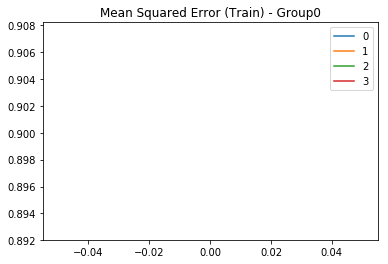

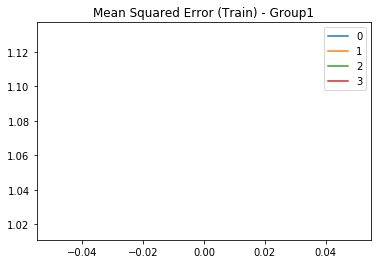

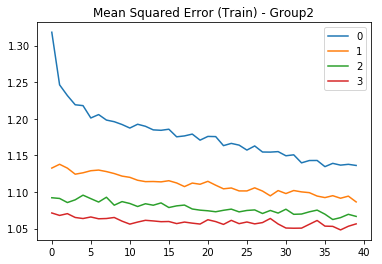

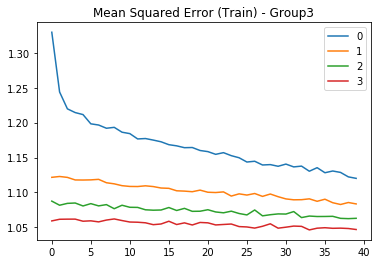

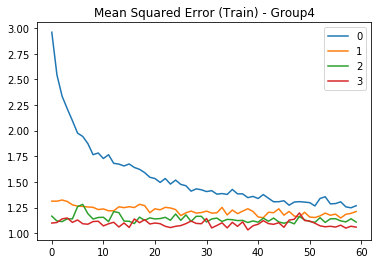

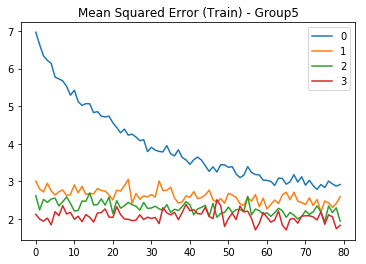

In [197]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ensemble_list:
            hist = hists_ensemble[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

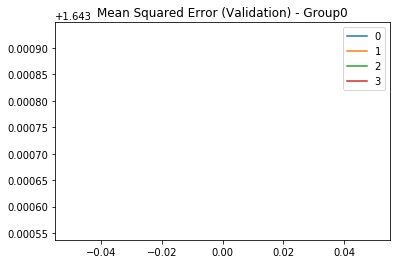

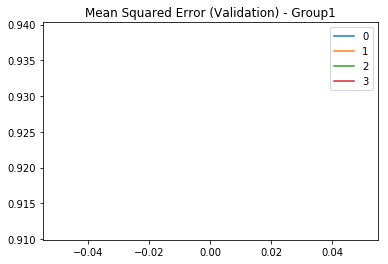

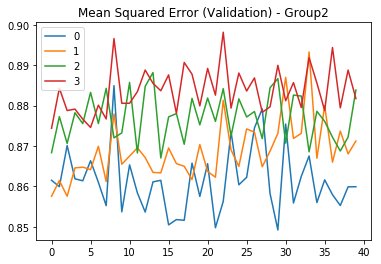

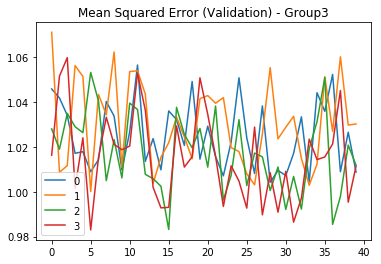

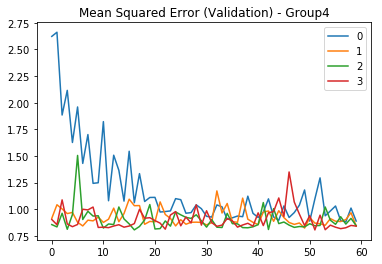

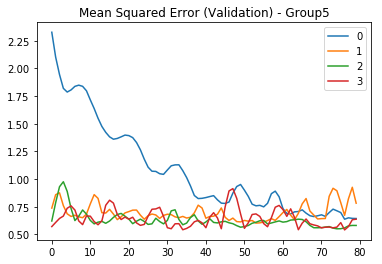

In [198]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ensemble_list:
            hist = hists_ensemble[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

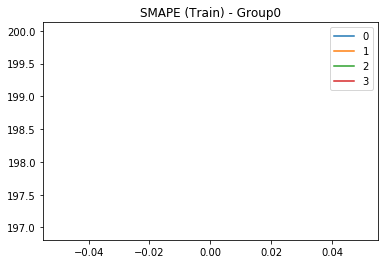

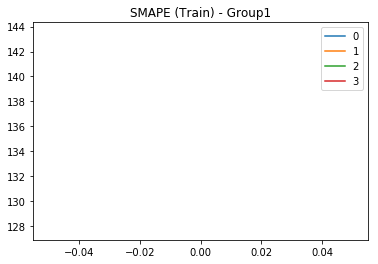

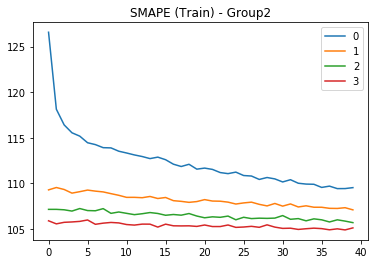

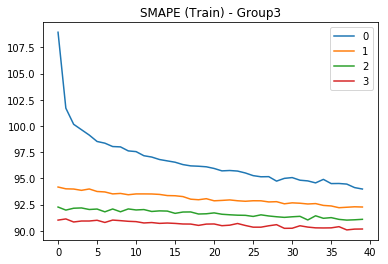

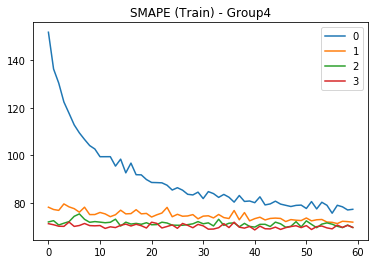

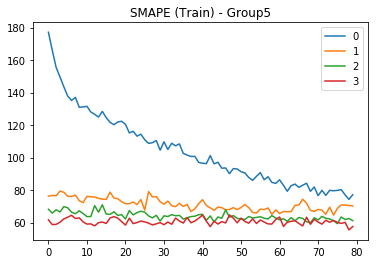

In [199]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ensemble_list:
            hist = hists_ensemble[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

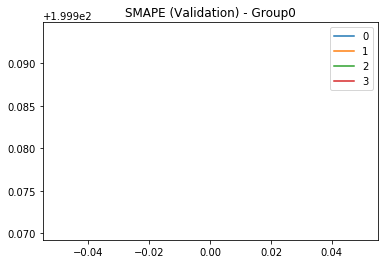

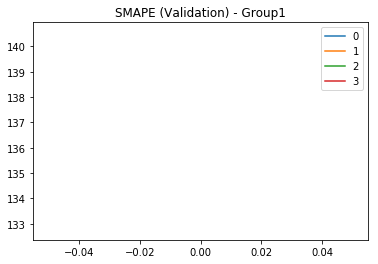

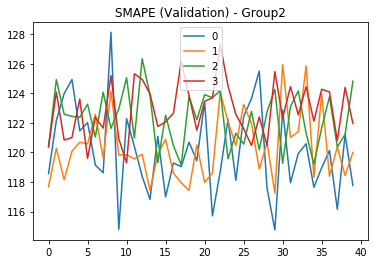

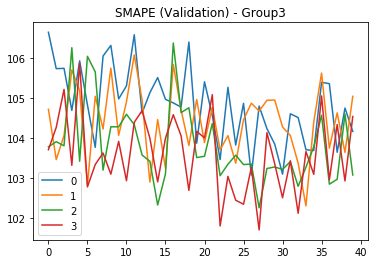

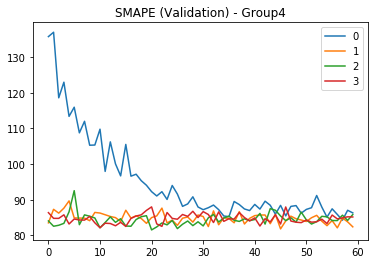

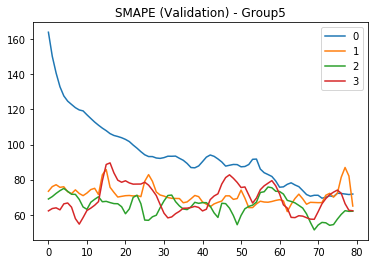

In [200]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ensemble_list:
            hist = hists_ensemble[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

In [201]:
hists = hists_ensemble[-1]

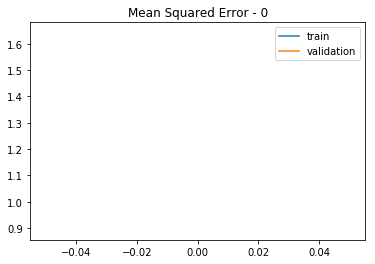

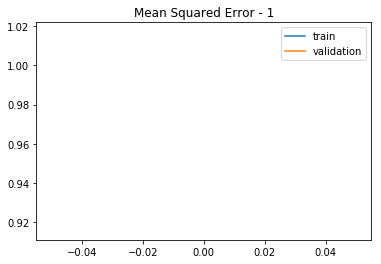

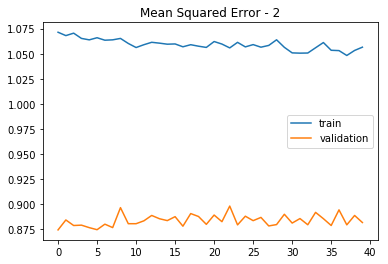

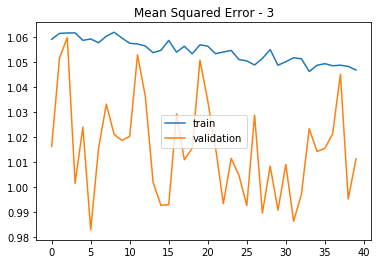

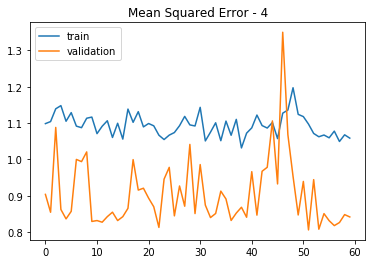

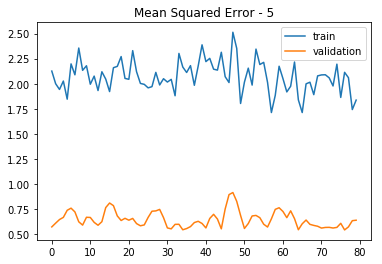

In [202]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

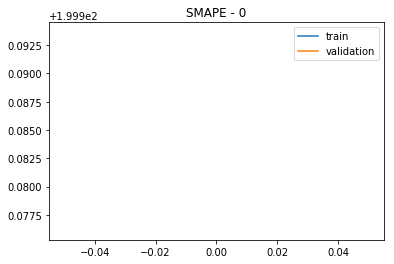

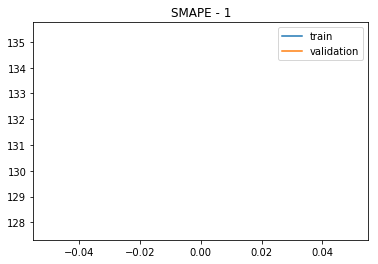

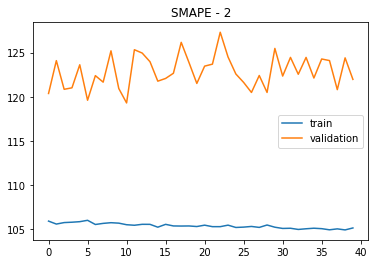

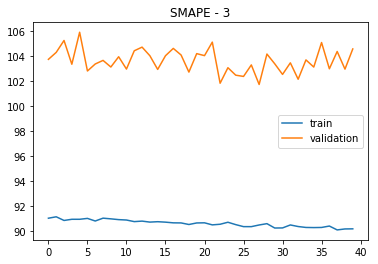

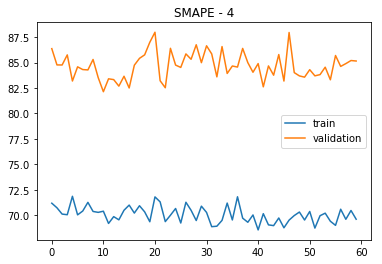

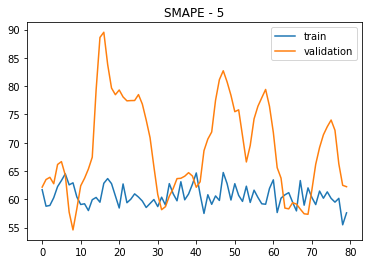

In [203]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

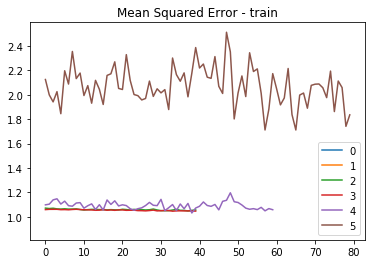

In [204]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

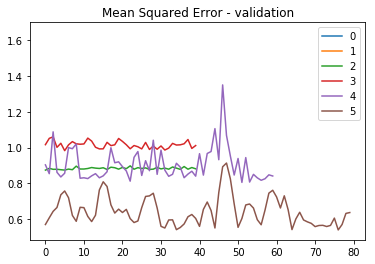

In [205]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

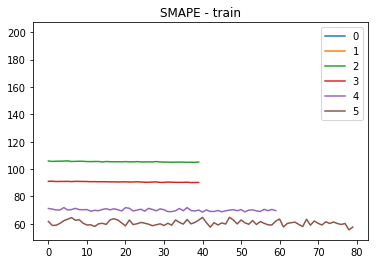

In [206]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

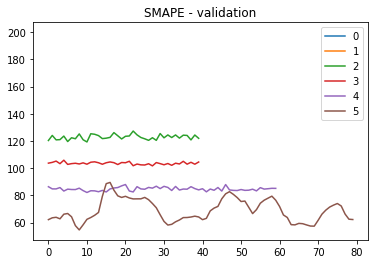

In [207]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using Output Set

if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))

### Predict for Output Set

In [208]:
Y_output_pred_list_ensemble = []
for models in models_ensemble:
    Y_output_pred_list = []
    for (gp, model, X) in zip(gp_list, models, X_output_list):
        print(gp)
        Y_output_pred_list.append(model.predict(X))
    Y_output_pred_list_ensemble.append(Y_output_pred_list)

0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5


Find the original index

In [209]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [210]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [211]:
for o in output_index_list:
    print(o.shape)

(1879,)
(23085,)
(43691,)
(75617,)
(740,)
(51,)


In [212]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([  1475,   3412,   3467, ..., 123025, 139119, 140151])

In [213]:
Y_output_pred_ensemble = []
for Y_output_pred_list in Y_output_pred_list_ensemble:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred_temp = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred_temp[index] = y

    Y_output_pred = np.array(Y_output_pred_temp)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ensemble.append(Y_output_pred)

del Y_output_pred_temp

In [214]:
# Inverse transform Y of output

Y_output_pred_ori_ensemble = []
for Y_output_pred in Y_output_pred_ensemble:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          output_center, output_scale))
    Y_output_pred_ori_ensemble.append(Y_output_pred_ori)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

### Model Score

In [215]:
# SMAPE scores for the model
if test_length:
    model_smape_score_ensmeble = []
    model_smape_score_0_ensmeble = []
    for Y_output_pred_ori in Y_output_pred_ori_ensemble:
        model_smape_score = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_score_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        print(model_smape_score, model_smape_score_0)
        
        model_smape_score_ensmeble.append(model_smape_score)
        model_smape_score_0_ensmeble.append(model_smape_score_0)
    print('-----------')
    print(np.mean(model_smape_score_ensmeble), np.mean(model_smape_score_0_ensmeble))

41.0290245555 44.163207063
40.8865408973 44.0107214683
40.9798076977 44.140572472
39.6400292148 43.1123599682
-----------
40.6338505913 43.8567152429


In [216]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape_score = smape(Y_output_raw, Y_output_fib)
    print(fib_smape_score)

40.4041165988


### Group Scores
For self-testing stage only

In [217]:
# Prediction Y_output in group
Y_output_pred_ori_list_ensemble = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list] 
                                   for Y_output_pred_ori in Y_output_pred_ori_ensemble]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ensemble[-1]  # in case you want to see one of them

In [218]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [219]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [220]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

In [221]:
if test_length: print(count_not_nan(Y_output_raw))

8904608


In [222]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    #gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
    #              in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ensemble = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)] 
                         for Y_output_pred_ori_list in Y_output_pred_ori_list_ensemble]
    gp_smape = gp_smape_ensemble[-1]
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape_score, '%6.2f' % model_smape_score_0)

n_not_nan_gp

### Individual Page Scores

In [223]:
if test_length:
    smape_Y_pred_ensemble = []
    #smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
    #                            in zip(Y_output_pred_ori, Y_output_raw)])
    for Y_output_pred_ori in Y_output_pred_ori_ensemble:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ensemble.append(smape_Y_pred)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


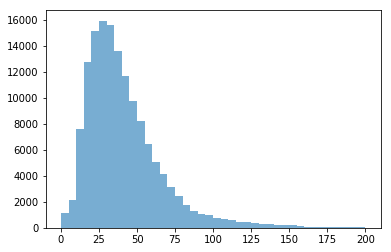

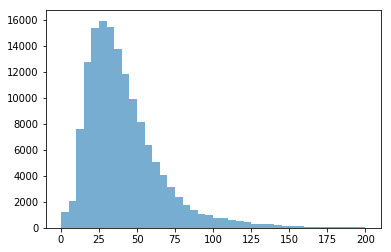

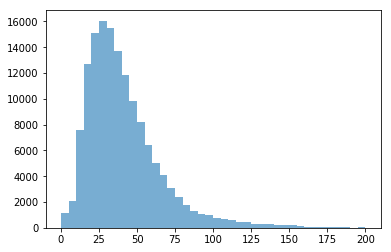

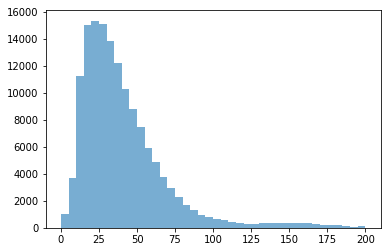

In [224]:
if test_length:
    for smape_Y_pred in smape_Y_pred_ensemble:
        plt.hist(smape_Y_pred, bins=40, alpha=0.6)
        #plt.yscale('log')
        plt.show()

### SMAPE for the Model

In [225]:
if test_length:
    smape_Y_pred_list_ensemble = []
    for smape_Y_pred in smape_Y_pred_ensemble:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ensemble.append(smape_Y_pred_list)

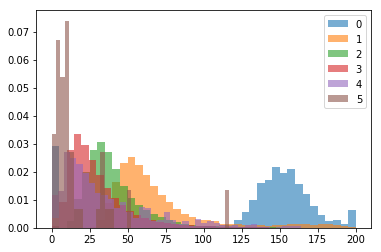

In [226]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

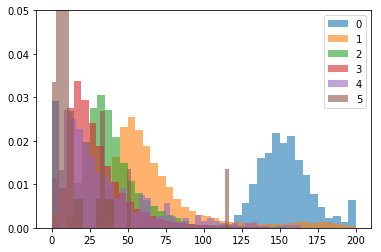

In [227]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

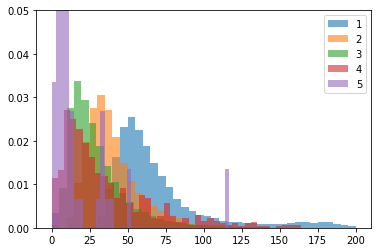

In [228]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

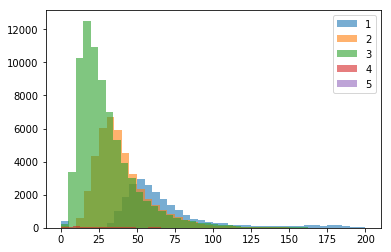

In [229]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

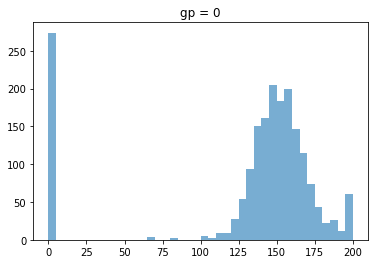

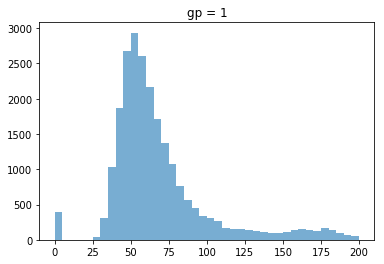

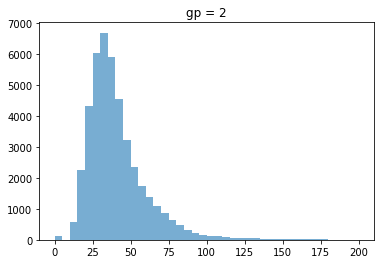

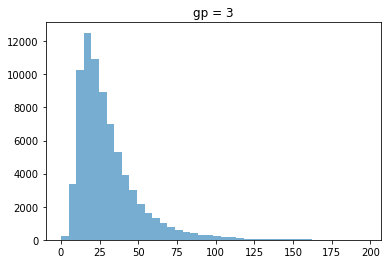

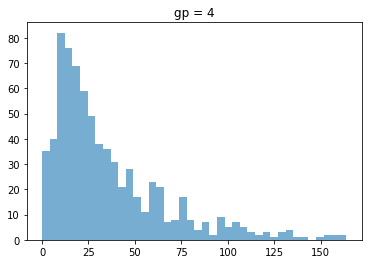

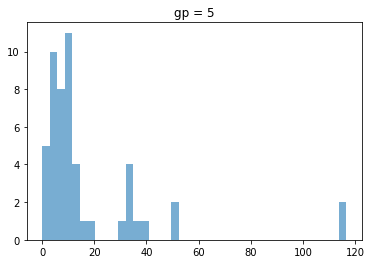

In [230]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### SMAPE for Fibonacci median

In [231]:
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [232]:
# Group SMAPE for Fib.
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [233]:
# Individual SMAPE for Fib.
if test_length:
    #smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
    #                           in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]
# The above two cells can be combined.

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


#### SMAPE distribution for Fib

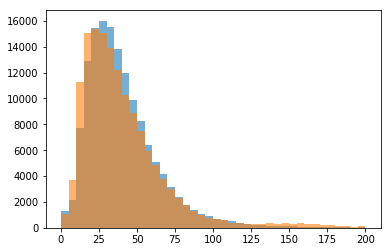

In [234]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

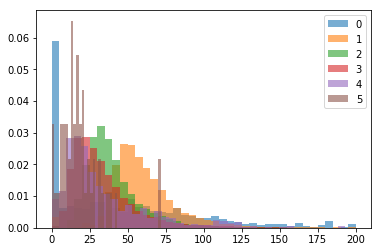

In [235]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

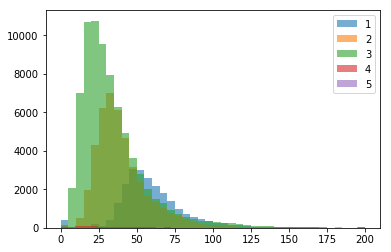

In [236]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

if test_length:
    for i in range(len(smape_Y_fib_list)):
        plt.hist(smape_Y_pred_list[i], bins=40, alpha=0.7, label='Model')
        plt.hist(smape_Y_fib_list[i], bins=40, alpha=0.5, label='Fib')
        plt.title('gp = '+str(i))
        plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### Models vs Fibonacci Median

In [237]:
if test_length:
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', sep='|', end='|')
    for run in ensemble_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', sep='|', end='|')
    for run in ensemble_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        for run in ensemble_list:
            print(' %7.3f ' % gp_smape_ensemble[run][gp], end='|')
        print('')

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 |
|--------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 120.371 | 112.424 | 119.635 | 152.338 |
|  23085 |  61.354 |  62.241 |  61.719 |  61.826 |  65.019 |
|  43691 |  40.612 |  40.683 |  40.707 |  40.669 |  40.936 |
|  75617 |  34.284 |  34.317 |  34.289 |  34.361 |  30.346 |
|    740 |  35.621 |  35.730 |  35.694 |  35.469 |  36.568 |
|     51 |  20.224 |  20.330 |  20.254 |  20.279 |  18.357 |


#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [238]:
Y_output_fib.shape

(145063, 1)

In [239]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [240]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [241]:
# The combined result
Y_output_fmc_ori_ensemble = []
for Y_output_pred_ori in Y_output_pred_ori_ensemble:
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    Y_output_fmc_ori_ensemble.append(Y_output_fmc_ori)

In [242]:
Y_output_fmc_ori

array([[ 29.70855342,  30.342796  ,  30.79325054, ...,  26.107034  ,
         25.67919917,  25.86198296],
       [ 23.45442109,  23.37336242,  23.99143865, ...,  24.13096244,
         23.5502447 ,  24.11092732],
       [  4.        ,   4.        ,   4.        , ...,   4.        ,
          4.        ,   4.        ],
       ..., 
       [ 29.2457002 ,  32.11537006,  33.19602974, ...,  26.48849901,
         25.62169562,  26.92283341],
       [  7.75      ,   7.75      ,   7.75      , ...,   7.75      ,
          7.75      ,   7.75      ],
       [ 11.80436302,  12.04034516,  12.62051132, ...,  12.80928913,
         12.2405651 ,  12.79547346]])

In [243]:
if test_length: 
    model_combined_smape_score_ensemble = []
    for run, Y_output_fmc_ori in zip(ensemble_list, Y_output_fmc_ori_ensemble):
        model_combined_smape_score = smape(Y_output_fmc_ori, Y_output_raw)
        model_combined_smape_score_ensemble.append(model_combined_smape_score)
        print('%6.3f' % model_combined_smape_score, '(%6.3f)' % model_smape_score, '-', model_name, run)
    model_combined_smape_score_ensemble_mean = np.mean(model_combined_smape_score_ensemble)
    print('%6.3f' % model_combined_smape_score_ensemble_mean)

40.444 (39.640) - model_9_CNN_with_Fibonacci_4_Ensemble 0
40.436 (39.640) - model_9_CNN_with_Fibonacci_4_Ensemble 1
40.462 (39.640) - model_9_CNN_with_Fibonacci_4_Ensemble 2
38.414 (39.640) - model_9_CNN_with_Fibonacci_4_Ensemble 3
39.939


In [244]:
model_name

'model_9_CNN_with_Fibonacci_4_Ensemble'

#### Combined Scores:
38.777 (39.377) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 2

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.174 (44.159) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 3

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

43.038 (43.990) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 1

43.479 (44.659) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 3

43.804 (45.033) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.948 (46.090) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 4

43.762 (44.885) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 3

43.805 (44.996) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 2

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## Case Study

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [245]:
view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

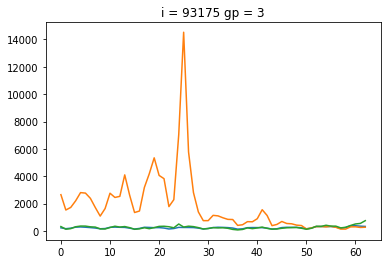

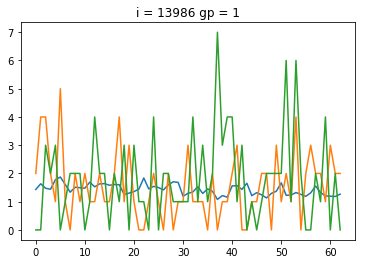

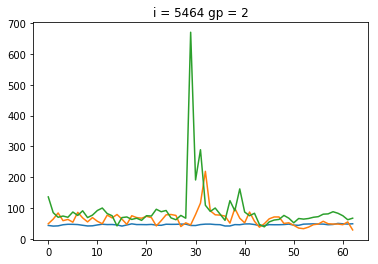

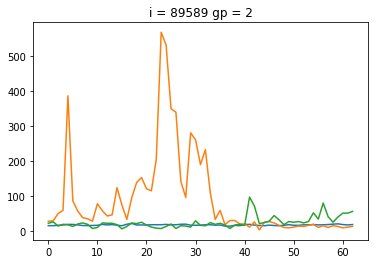

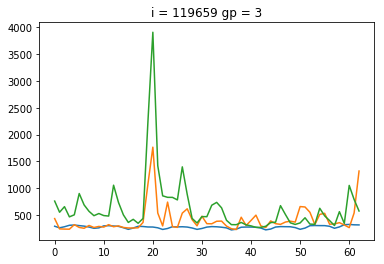

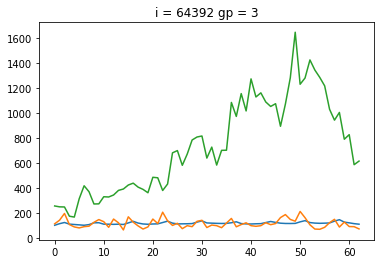

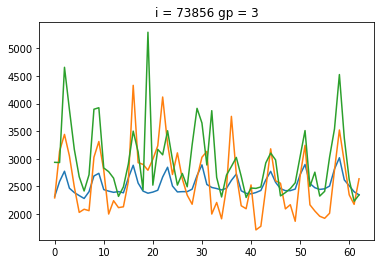

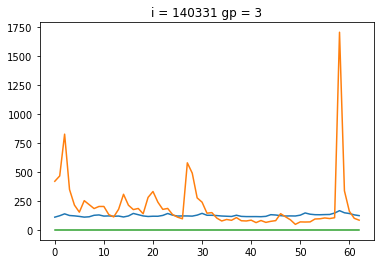

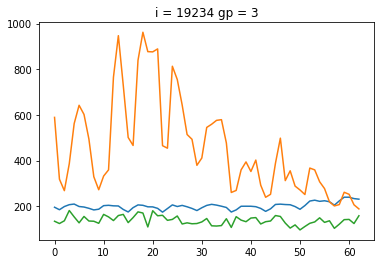

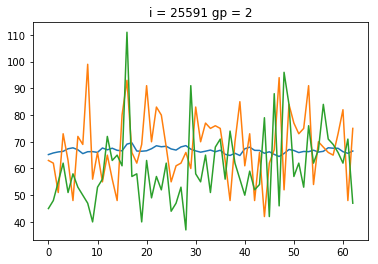

In [246]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

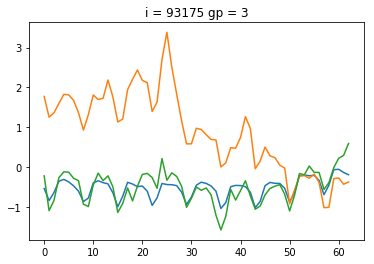

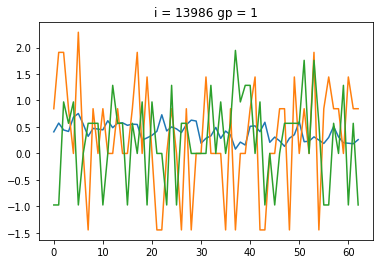

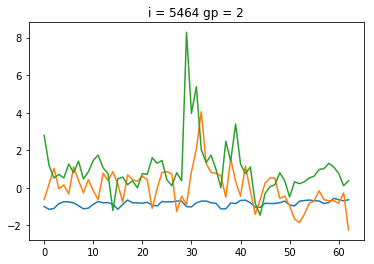

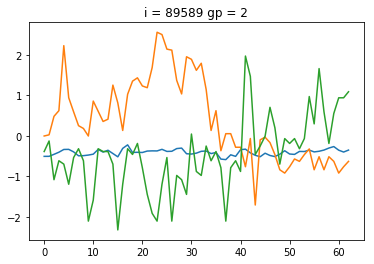

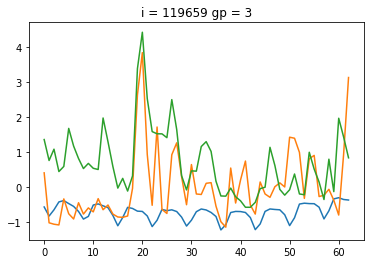

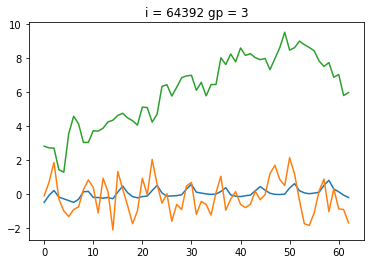

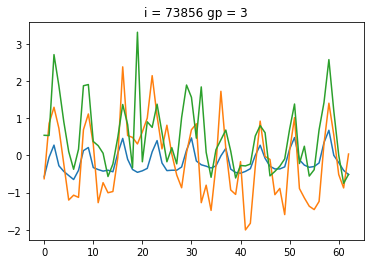

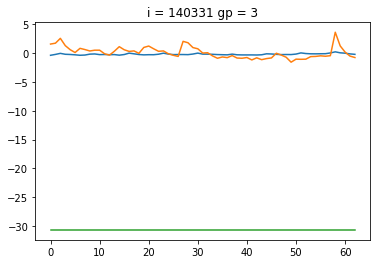

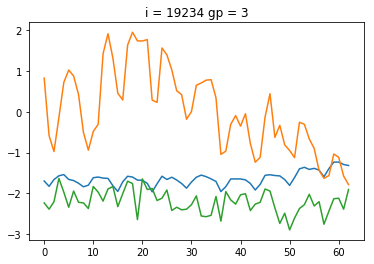

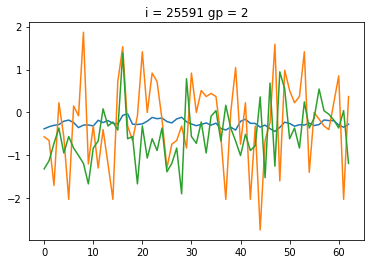

In [247]:
view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

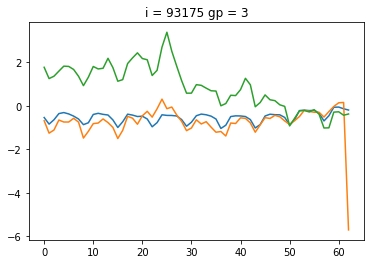

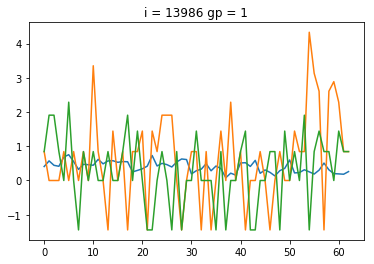

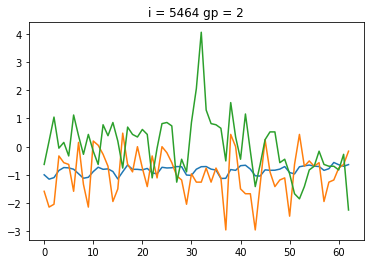

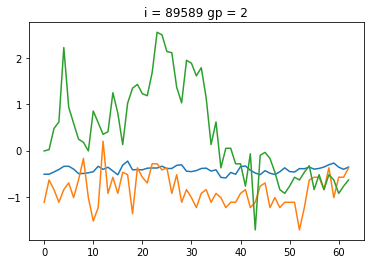

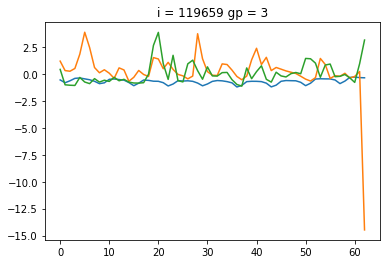

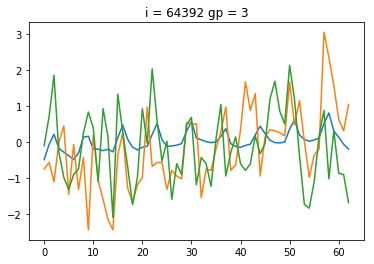

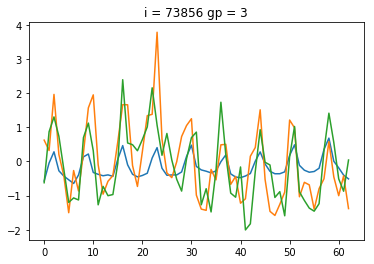

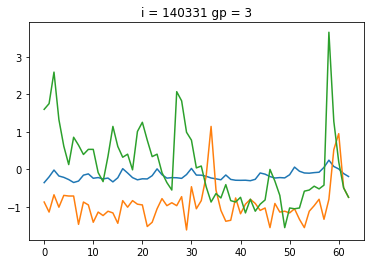

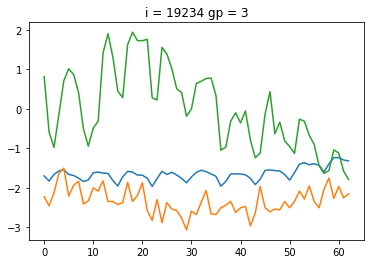

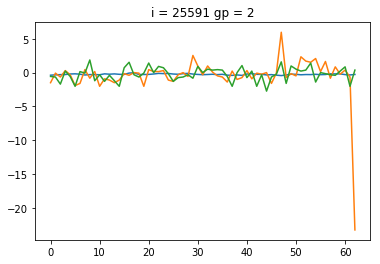

In [248]:
if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

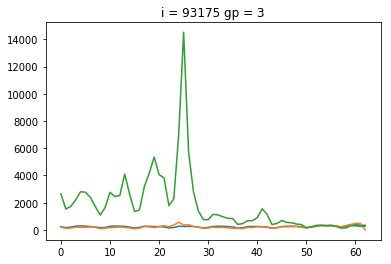

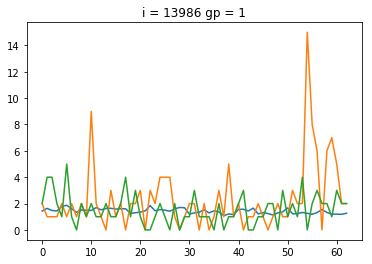

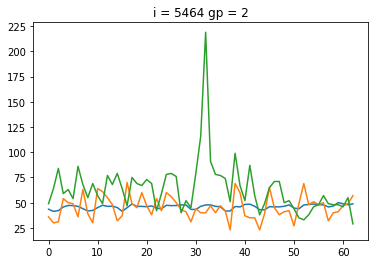

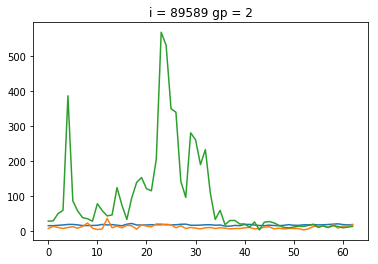

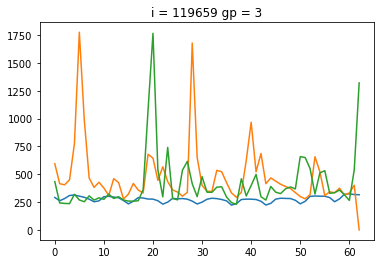

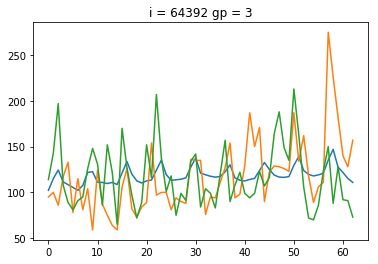

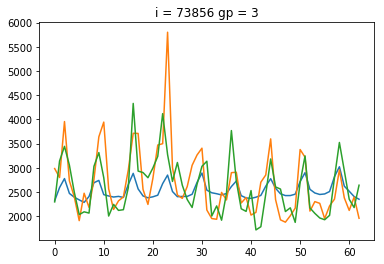

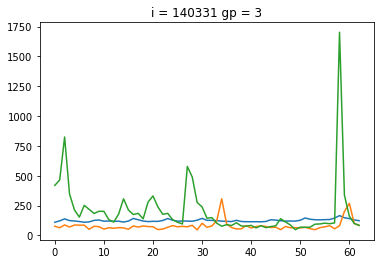

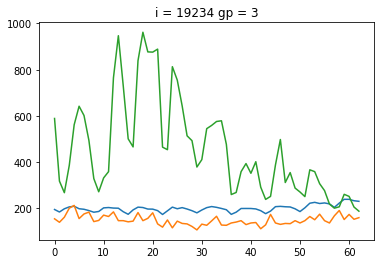

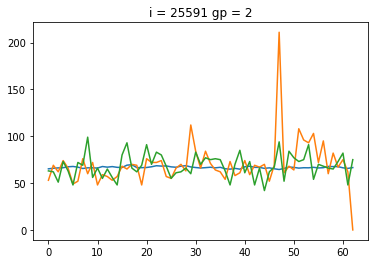

In [249]:
if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

In [250]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

In [251]:
view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

[26.891236272976126,
 77.658520736703792,
 18.62204975638581,
 56.050941269583618,
 45.087670846656621,
 23.170431803288022,
 15.24765369848719,
 55.772496330747579,
 29.992813233521481,
 15.567186110644224]

In [252]:
view_list_review = [score < model_smape_score for score in view_list_smape]; view_list_review

[True, False, True, False, False, True, True, False, True, True]

In [253]:
view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

[93175, 5464, 64392, 73856, 19234, 25591]

In [254]:
view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

[13986, 89589, 119659, 140331]

#### Good cases

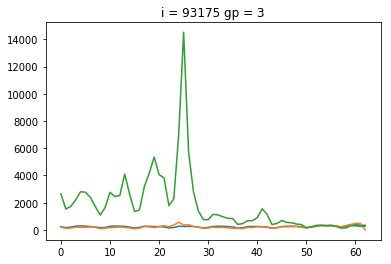

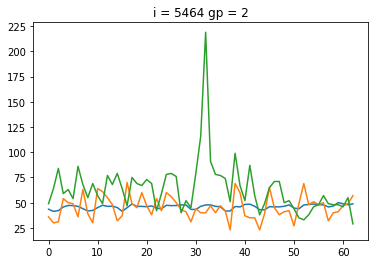

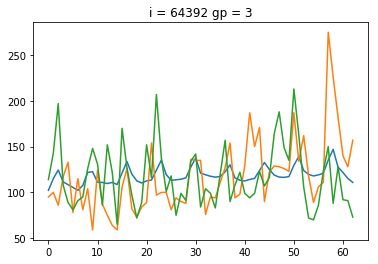

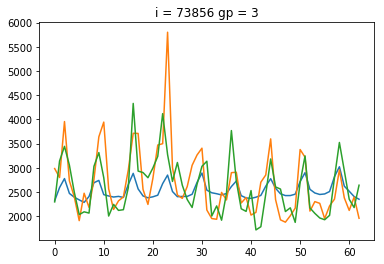

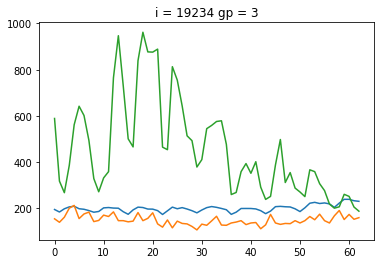

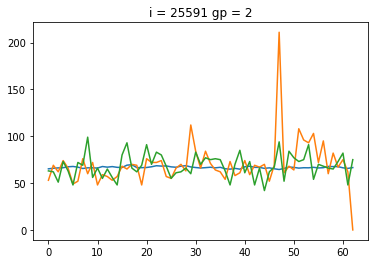

[93175, 5464, 64392, 73856, 19234, 25591]

In [255]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

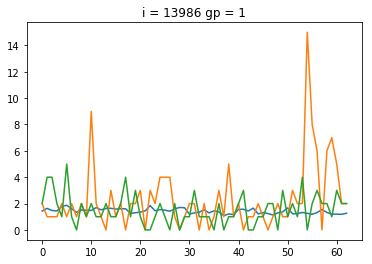

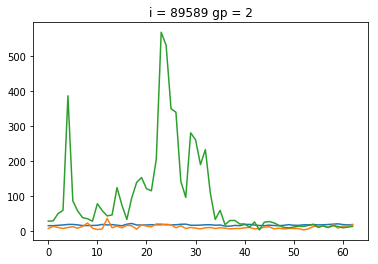

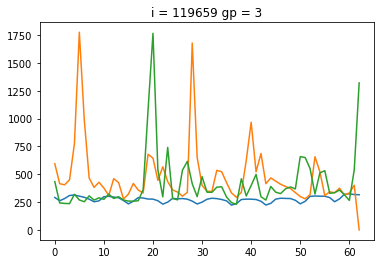

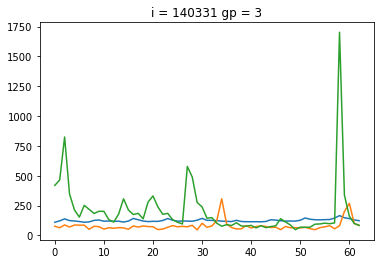

[13986, 89589, 119659, 140331]

In [256]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

In [257]:
print(output_center[view_list_good].reshape(-1))
print(output_center[view_list_bad].reshape(-1))

[ 2.61225391  1.78532984  2.07280115  3.41796964  2.61489722  1.85125835]
[ 0.30103     1.46612587  2.56555268  2.14921911]


In [258]:
print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

[ 0.45758495  0.13744919  0.12048413  0.09144428  0.18993217  0.07964336]
[ 0.20849044  0.50503777  0.17725717  0.29619523]


In [259]:
output_gp[view_list_good]

array([3, 2, 3, 3, 3, 2])

In [260]:
output_gp[view_list_bad]

array([1, 2, 3, 3])

In [261]:
gp_smape

[152.3381925953436,
 65.019182063884557,
 40.935882715829898,
 30.346481869931459,
 36.568111167675291,
 18.356991435753901]

In [262]:
gp_n

[1879, 23085, 43691, 75617, 740, 51]

#### Case 93175

In [263]:
i = 93175

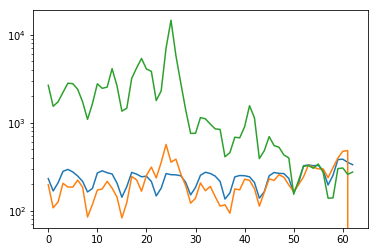

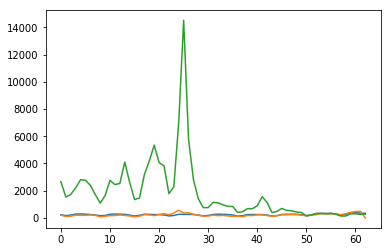

In [264]:
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

In [265]:
smape(Y_output_pred_ori[i], Y_output_raw[i])

26.891236272976126

In [266]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 2.61225391]),
 array([ 2.61225391]),
 array([ 0.4493528]),
 array([ 0.45758495]))

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

In [267]:
review_Y = np.array([score < model_smape_score for score in smape_Y_pred])

In [268]:
np.arange(len(Y_output_pred))

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [269]:
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; good_Y_index

array([     0,      3,      8, ..., 144962, 145021, 145042])

In [270]:
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; bad_Y_index

array([     1,      2,      4, ..., 145060, 145061, 145062])

In [271]:
good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

In [272]:
good_input_center = input_center[good_Y_index]
good_output_center = output_center[good_Y_index]
bad_input_center = input_center[bad_Y_index]
bad_output_center = output_center[bad_Y_index]

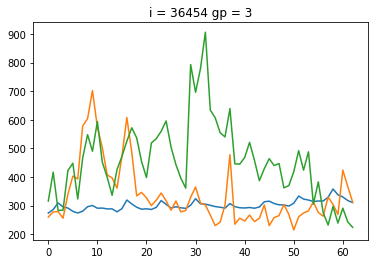

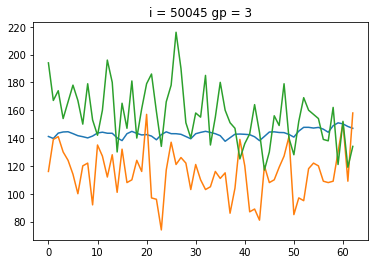

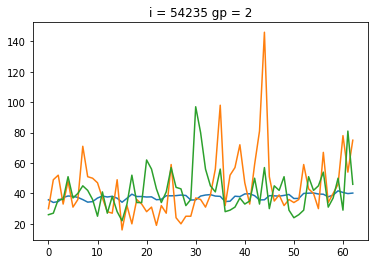

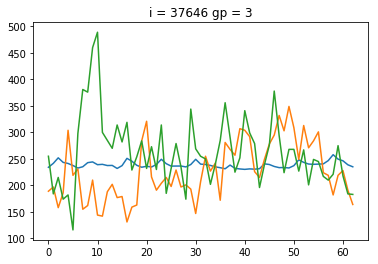

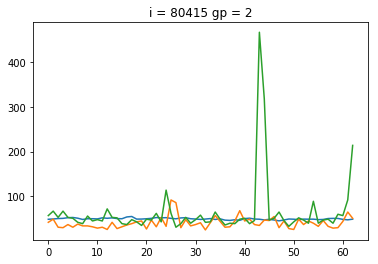

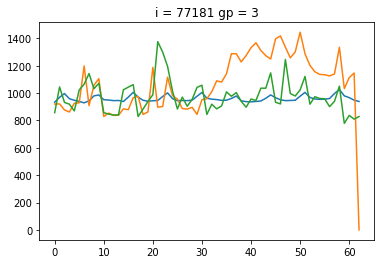

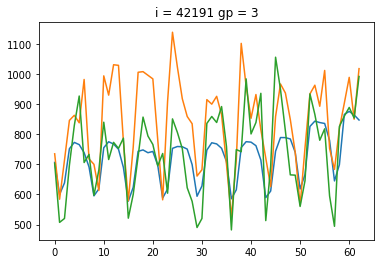

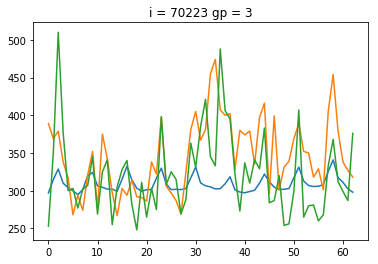

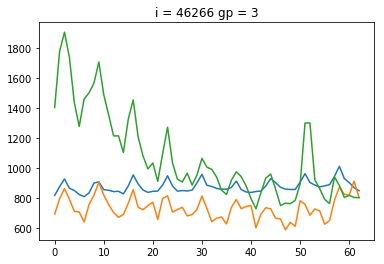

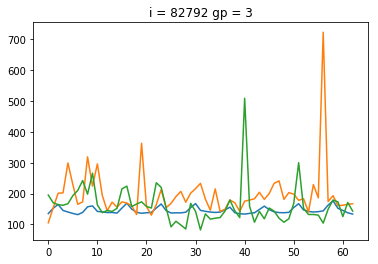

[36454, 50045, 54235, 37646, 80415, 77181, 42191, 70223, 46266, 82792]

In [273]:
examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

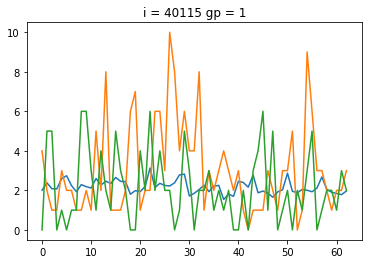

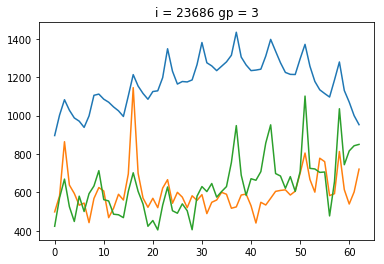

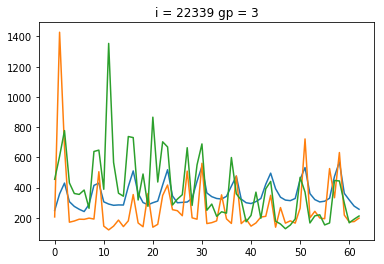

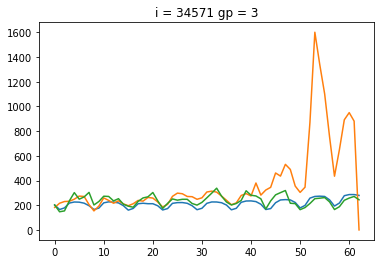

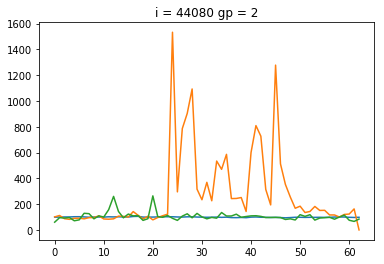

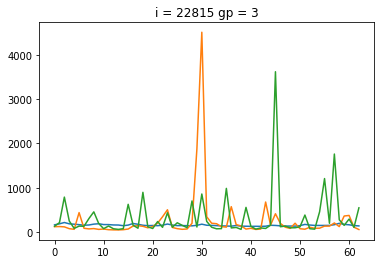

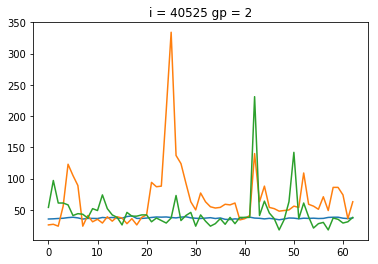

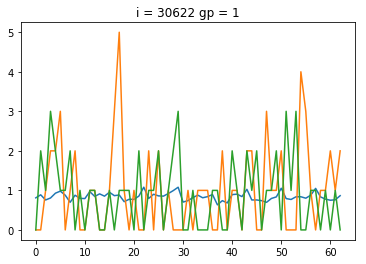

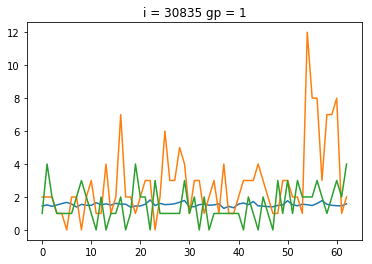

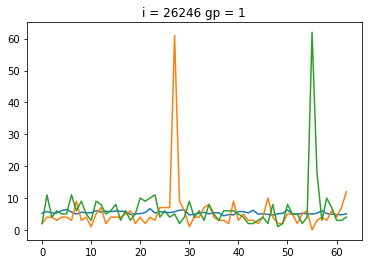

[40115, 23686, 22339, 34571, 44080, 22815, 40525, 30622, 30835, 26246]

In [274]:
examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

In [275]:
good_output_scale.min(), good_output_scale.max()

(0.0053654329977268714, 1.3484600516008696)

In [276]:
bad_output_scale.min(), bad_output_scale.max()

(0.0016980961003407436, 2.0382773961171501)

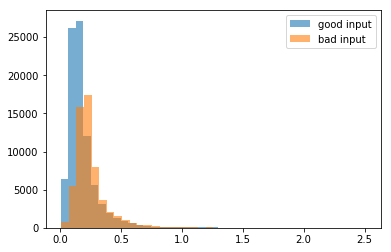

In [277]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

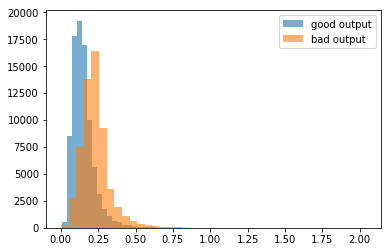

In [278]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

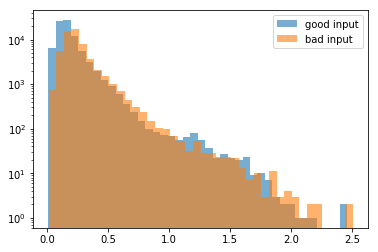

In [279]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

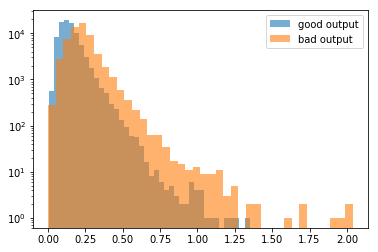

In [280]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

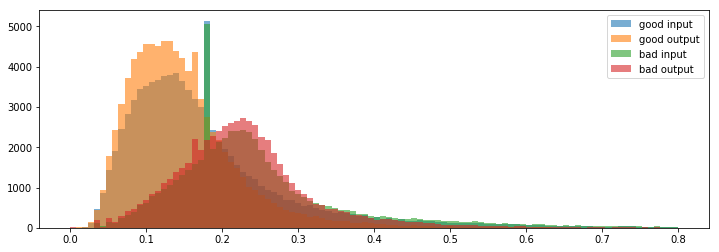

In [281]:
plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

In [282]:
np.mean(good_output_scale), np.mean(good_input_scale)

(0.14825541996351807, 0.18774204507754769)

In [283]:
np.mean(bad_output_scale), np.mean(bad_input_scale)

(0.23017505917343598, 0.25765843530299659)

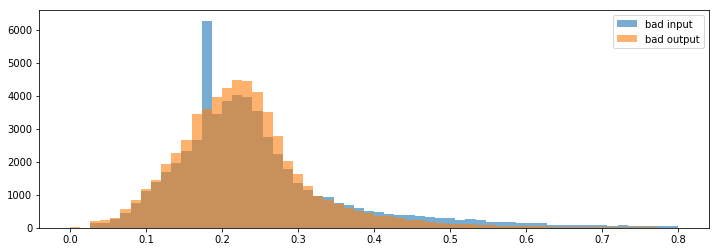

In [284]:
plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

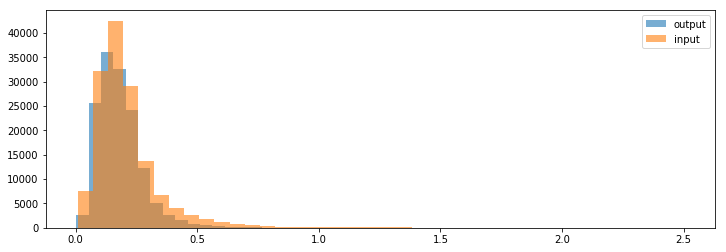

In [285]:
plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

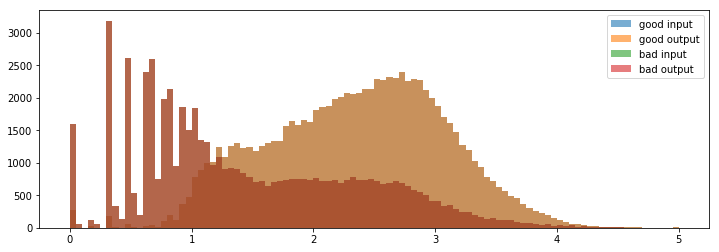

In [286]:
plt.figure(figsize=(12,4))
plt.hist(good_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

In [287]:
gc.collect()

181819

### stdev/median

output_factor_1 = (output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [288]:
Y_output_dates

Index(['2017-06-30', '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
       '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08', '2017-07-09',
       '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13', '2017-07-14',
       '2017-07-15', '2017-07-16', '2017-07-17', '2017-07-18', '2017-07-19',
       '2017-07-20', '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
       '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29',
       '2017-07-30', '2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03',
       '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07', '2017-08-08',
       '2017-08-09', '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
       '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
       '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
       '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27', '2017-08-28',
       '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object')

In [289]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_fmc_ori, columns = Y_output_dates)  # using combined result
result_df

NameError: name 'result_df' is not defined

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]